In [ ]:
# dataset taken from https://www.kaggle.com/puneet6060/intel-image-classification
# developing classification model for differentiating between Building, Forests, and Mountains

In [1]:
!pip install torch==1.8.1

In [3]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 727kB 6.4MB/s 
     |████████████████████████████████| 194kB 25.3MB/s 
     |████████████████████████████████| 1.2MB 20.8MB/s 
     |████████████████████████████████| 51kB 4.9MB/s 
     |████████████████████████████████| 61kB 6.1MB/s 
     |████████████████████████████████| 12.8MB 254kB/s 
     |████████████████████████████████| 776.8MB 22kB/s 
     |████████████████████████████████| 51kB 4.8MB/s 
ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.7.1 which is incompatible.
Mounted at /content/gdrive


In [4]:
from fastbook import *
from fastai.vision.widgets import *

In [ ]:
# connecting to GDrive for accessing the dataset
# not all images were used only 200 images from each category were used to train the model

In [5]:
path_imgs = 'drive/MyDrive/Image Classification/'
exam_img_path = path_imgs+'Mountains/1700.jpg'

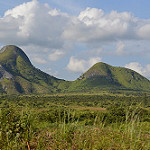

In [9]:
im = Image.open(exam_img_path)
im.to_thumb(224,224)

In [10]:
mountains = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [12]:
dls = mountains.dataloaders(path_imgs)

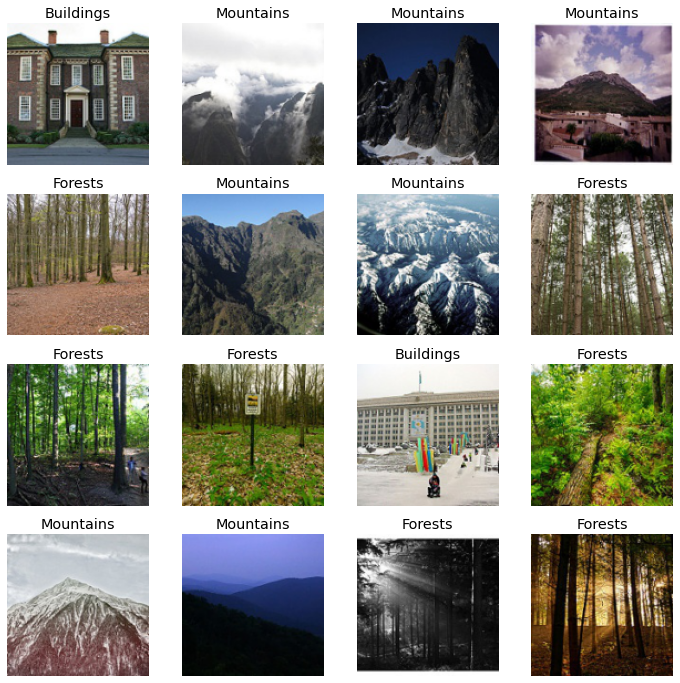

In [15]:
dls.valid.show_batch(max_n=16, nrows=4)

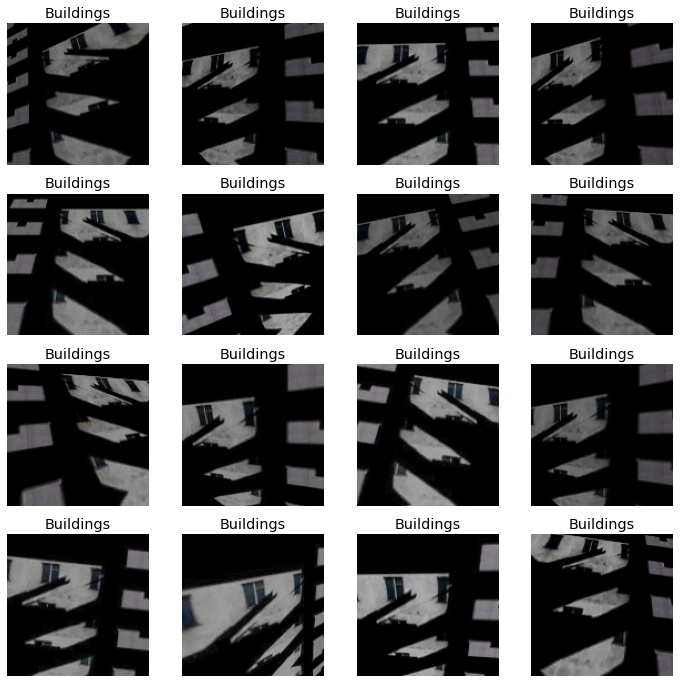

In [20]:
mountains = mountains.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = mountains.dataloaders(path_imgs)
dls.train.show_batch(max_n=16, nrows=4, unique=True)

In [22]:
mountains = mountains.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = mountains.dataloaders(path_imgs)

In [25]:
learn = cnn_learner(dls, resnet18, metrics=[error_rate, accuracy])
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.245628,0.829596,0.183333,0.816667,01:44


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.148745,0.056144,0.008333,0.991667,02:19
1,0.119289,0.061842,0.025000,0.975000,02:19
2,0.096137,0.072246,0.025000,0.975000,02:18
3,0.080424,0.062281,0.016667,0.983333,02:21


In [26]:
# https://forums.fast.ai/t/plotting-metrics-after-learning/69937/3
from fastai.imports import *
from fastai.torch_core import *
from fastai.learner import *
    
@patch
@delegates(subplots)
def plot_metrics(self: Recorder, nrows=None, ncols=None, figsize=None, **kwargs):
    metrics = np.stack(self.values)
    names = self.metric_names[1:-1]
    n = len(names) - 1
    if nrows is None and ncols is None:
        nrows = int(math.sqrt(n))
        ncols = int(np.ceil(n / nrows))
    elif nrows is None: nrows = int(np.ceil(n / ncols))
    elif ncols is None: ncols = int(np.ceil(n / nrows))
    figsize = figsize or (ncols * 6, nrows * 4)
    fig, axs = subplots(nrows, ncols, figsize=figsize, **kwargs)
    axs = [ax if i < n else ax.set_axis_off() for i, ax in enumerate(axs.flatten())][:n]
    for i, (name, ax) in enumerate(zip(names, [axs[0]] + axs)):
        ax.plot(metrics[:, i], color='#1f77b4' if i == 0 else '#ff7f0e', label='valid' if i > 0 else 'train')
        ax.set_title(name if i > 1 else 'losses')
        ax.legend(loc='best')
    plt.show()


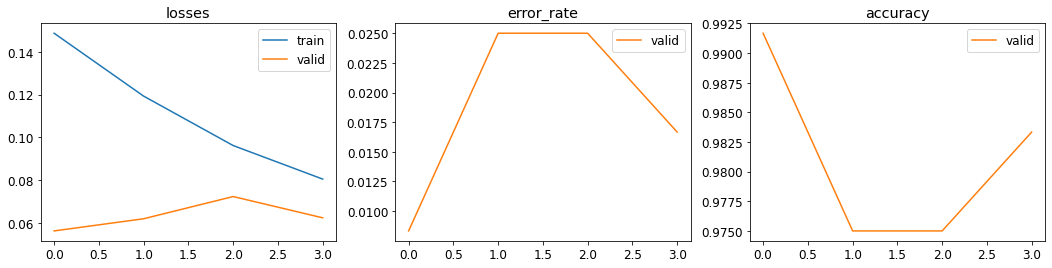

In [27]:
learn.recorder.plot_metrics()

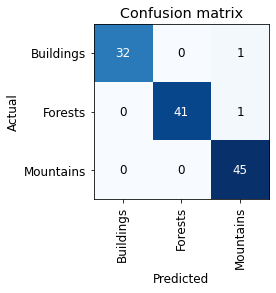

In [28]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

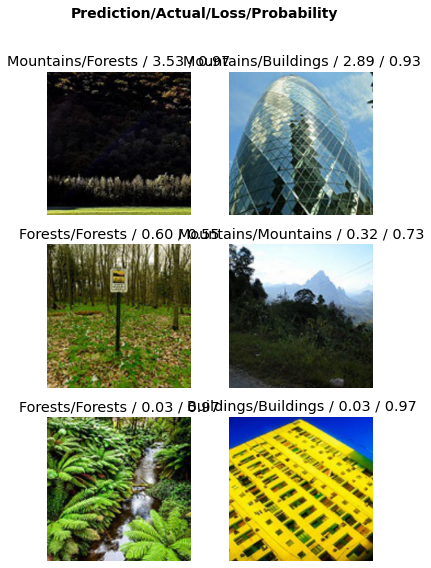

In [31]:
interp.plot_top_losses(6, nrows=3)

In [32]:
learn.export()
path = Path()
path.ls(file_exts='.pkl')
learn_inf = load_learner(path/'export.pkl')

In [33]:
learn_inf.dls.vocab

['Buildings', 'Forests', 'Mountains']

In [34]:
#hide_output
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [36]:
img = PILImage.create(btn_upload.data[-1])
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(224,224))
out_pl

Output()

In [37]:
pred,pred_idx,probs = learn_inf.predict(img)

In [38]:
#hide_ouatput
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: Buildings; Probability: 1.0000')

In [ ]:
btn_run = widgets.Button(description='Classify')
btn_run

In [44]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [45]:
btn_upload = widgets.FileUpload()

In [46]:
#hide_output
VBox([widgets.Label('Select your Image!'), 
      btn_upload, btn_run, out_pl, lbl_pred])

In [ ]:
!pip install voila
!jupyter serverextension enable --sys-prefix voila 